# TSMC 隔日股價漲、跌 監督式學習分類模型分析比較與評估
This notebook demonstrates the process of training and comparing three classification models (Logistic Regression, Random Forest, XGBoost) to predict next-day price movement of TSMC.

In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5a1decb07488171d9eced0978afa39fdc23a0d0c6a2b93e00950bdf89b7fbc10
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
# Used packages for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta import add_all_ta_features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance


In [ ]:
#### Download the data through yFinance API

In [4]:
import yfinance as yf

data = yf.download(
    ["2330.TW"],
    start="2020-01-01",
    end="2025-06-03",
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    prepost=False,
    threads=True,
)

# Write the raw data to the CSV file
data.to_csv("tsmc2330.csv", encoding="utf-8-sig")

[*********************100%***********************]  1 of 1 completed


#### 資料預處理

In [ ]:
# header=1 表示跳過第一列（原本的header），直接把第二列當作欄位名稱
df = pd.read_csv('tsmc2330.csv', header=1)

# 刪除第一列（原資料的第一列，現在是索引0）
df = df.drop(0).reset_index(drop=True)
df.rename(columns={'A1': 'Date'}, inplace=True)

#print("原本欄位名稱：", df.columns.tolist())

# 修改第一欄的欄位名稱
cols = df.columns.tolist()
cols[0] = 'Date'  # 改成你想要的新名稱
df.columns = cols

# 確認修改後欄位名稱
#print("修改後欄位名稱：", df.columns.tolist())

# 儲存結果
df.to_csv('tsmc2330.csv', index=False)

##### 特徵工程：加入技術指標 (MA5, MA10, MA20, RSI, BB band_upper, BB band_lower.),
##### 將Return欄 漲、跌欄位標準化改為 0(跌、平盤), 1(漲)，並放在最後一欄 Target 做為目標值

In [ ]:
import pandas as pd
import numpy as np

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(price, slow=26, fast=12, signal=9):
    ema_fast = price.ewm(span=fast).mean()
    ema_slow = price.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    return macd, signal_line

def compute_bollinger_bands(price, window=20, num_std=2):
    ma = price.rolling(window=window).mean()
    std = price.rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    return upper_band, lower_band


# 1. 讀取資料
df = pd.read_csv("tsmc2330.csv")

# 2. 新增技術指標
df["Return"] = df["Close"].pct_change()*100
df["MA5"] = df["Close"].rolling(window=5).mean()
df["MA10"] = df["Close"].rolling(window=10).mean()
df["MA20"] = df["Close"].rolling(window=20).mean()
df["Price_Change"] = df["Close"] - df["Open"]

# RSI
df["RSI"] = compute_rsi(df["Close"])

# MACD & Signal Line
df["MACD"], df["MACD_Signal"] = compute_macd(df["Close"])

# Bollinger Bands
df["BB_Upper"], df["BB_Lower"] = compute_bollinger_bands(df["Close"])

# 3. 處理漲跌目標欄位
#df["Increase"] = df["Increase"].str.replace("%", "").astype(float)
#標準化 "return" 成為Target 欄位: -1 (跌) 0 (漲), 1 (漲)
df["Target"] = df['Return'].apply(lambda x: 1 if x > 0 else (0 if x < 0 else 0))

# 移除缺失值
df.dropna(inplace=True)
#df.head()


df.to_csv('tsmc2330-1.csv', index = False)

#### 讀取資料

In [ ]:
# 🔹 讀取資料
df = pd.read_csv("tsmc2330-1.csv")
#df["Date"] = pd.to_datetime(df["Date"])
#df = df.sort_values("Date")
df.head()

,Date,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
0,2020-02-07,295.656420,296.104384,292.072706,293.864563,28798327.0,-1.353393,291.714343,292.520682,297.403485,-1.791857,43.065688,-1.495600,-1.419220,312.346986,282.459984,0
1,2020-02-10,288.041024,293.864560,287.593060,293.416595,30632424.0,-0.152440,293.954163,291.893530,296.888329,5.375571,41.044784,-1.408228,-1.417001,311.623940,282.152717,0
2,2020-02-11,296.104438,297.896295,295.656473,297.000366,27524935.0,1.221393,295.118878,291.759143,296.529961,0.895929,42.753644,-1.083419,-1.349789,310.863294,282.196627,1
3,2020-02-12,298.792155,301.031976,298.344190,300.136047,37612639.0,1.055784,296.462769,291.938324,296.664349,1.343893,41.911692,-0.605638,-1.200075,311.084076,282.244623,1
4,2020-02-13,302.823833,302.823833,300.136047,300.136047,22757021.0,0.000000,296.910724,293.595786,296.910732,-2.687785,45.967652,-0.227407,-1.004618,311.393965,282.427498,0


In [ ]:
features = df.drop(columns=["Date", "Target"])  # 特徵值不包含 日期 及 Target 欄位
X = features
y = df["Target"]  #設定目標值在 Target 欄位

#### 敘述統計

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Return,MA5,MA10,MA20,Price_Change,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower,Target
count,1292.000000,1292.000000,1292.000000,1292.000000,1.292000e+03,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000
mean,593.305409,597.750969,588.440548,593.023439,3.642305e+07,0.106940,592.000669,590.683966,588.075245,-0.281970,53.467778,3.500465,3.446634,624.127064,552.023426,0.486068
std,216.843517,218.910459,215.014329,216.856409,2.091602e+07,1.891261,216.438218,215.953789,214.881305,7.094025,16.739242,12.750818,11.993926,229.825345,201.614221,0.499999
min,227.965965,228.870592,213.039622,224.347458,0.000000e+00,-9.978772,234.465366,240.714258,246.500179,-36.509924,6.666705,-47.632351,-39.759963,264.813422,216.864533,0.000000
25%,469.741803,473.417376,466.172561,469.420067,2.250091e+07,-0.930228,468.809508,468.026600,462.705652,-3.768589,41.153759,-3.068060,-2.946628,496.692551,435.847023,0.000000
50%,543.867455,547.890564,539.793684,544.455048,3.194742e+07,0.000000,544.535034,544.985727,545.646255,0.000000,52.683474,2.600404,2.635905,568.228898,517.630623,0.000000
75%,619.563508,623.826464,612.868901,619.787689,4.325209e+07,1.104992,620.297284,614.580801,606.893298,2.878510,65.572719,10.264909,10.043545,642.701412,570.835902,1.000000
max,1139.828227,1149.739776,1124.960938,1124.960938,1.663077e+08,9.974109,1110.093628,1101.668799,1096.217438,40.826760,100.000000,43.913142,39.650306,1136.998153,1057.548329,1.000000


#### 上面的特徵 存放各個特徵變數的資料。
除了 "Date","Target" 2 個欄位外，其餘欄位做 RobustScalor 標準化並寫入 tsmc2330-2_Robust.csv，"Date","Target" 2欄原始資料請一併寫入至原來的欄位位置。

In [ ]:
from sklearn.preprocessing import RobustScaler

# 需要標準化的欄位
feature_cols = [col for col in df.columns if col not in ["Date", "Target"]]

# RobustScaler 標準化
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# 寫入 CSV
df_scaled.to_csv("tsmc2330-2_Robust.csv", index=False)

使用 Prof. J.W.Tukey 在1977年於Exploratory data analysis 所發表的方式計算 tsmc2330-2_Robust.csv 各欄的盒鬚圖及長條圖的常態分佈圖、Q-Q plot. ("Date", "Target" 2欄不用畫圖) 觀察資料離群及常態分布狀態

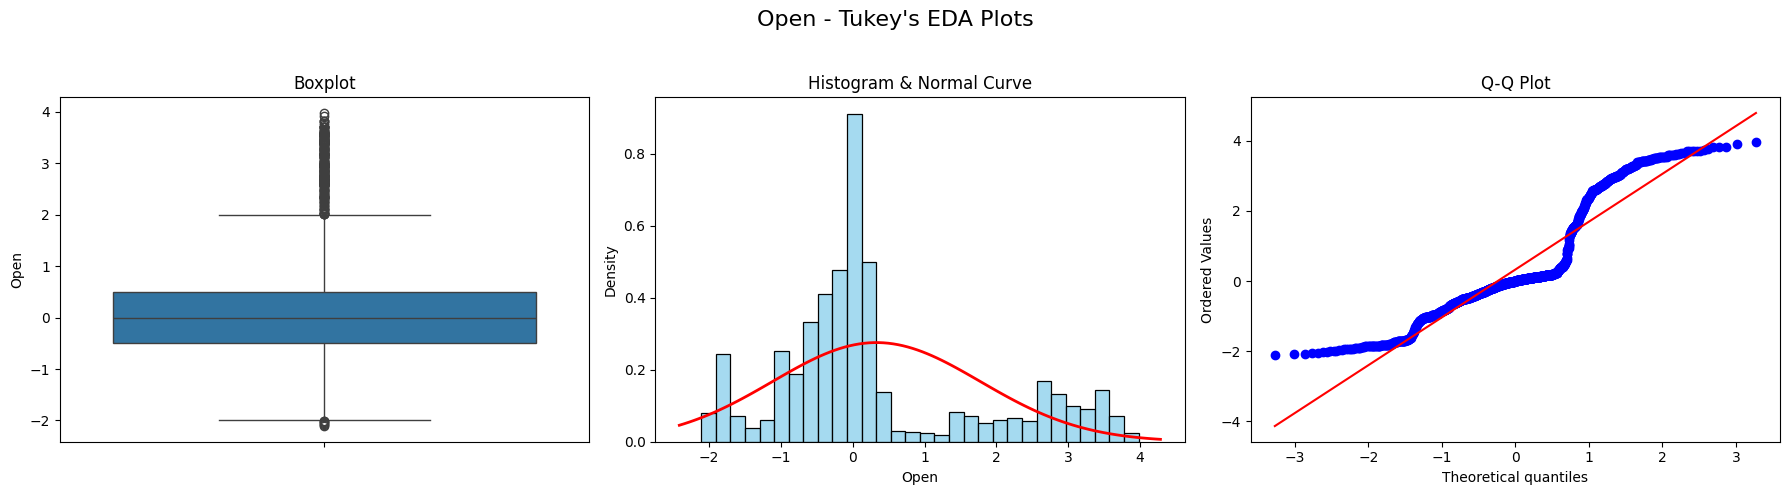

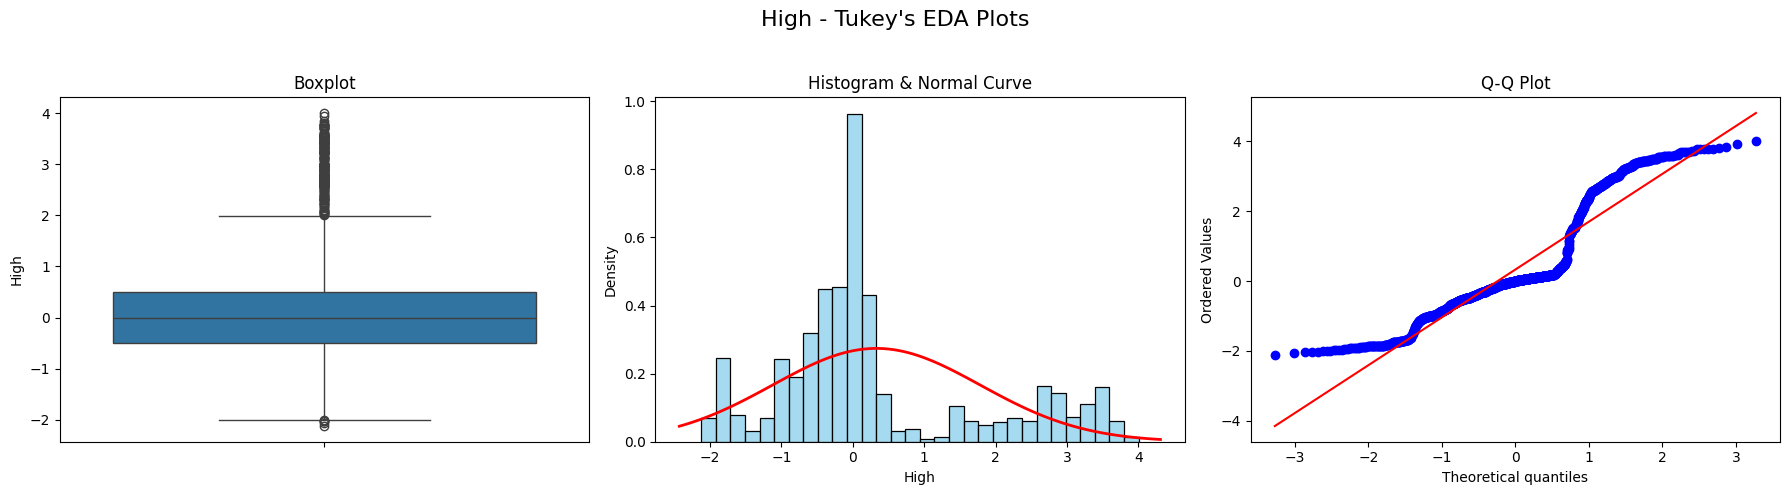

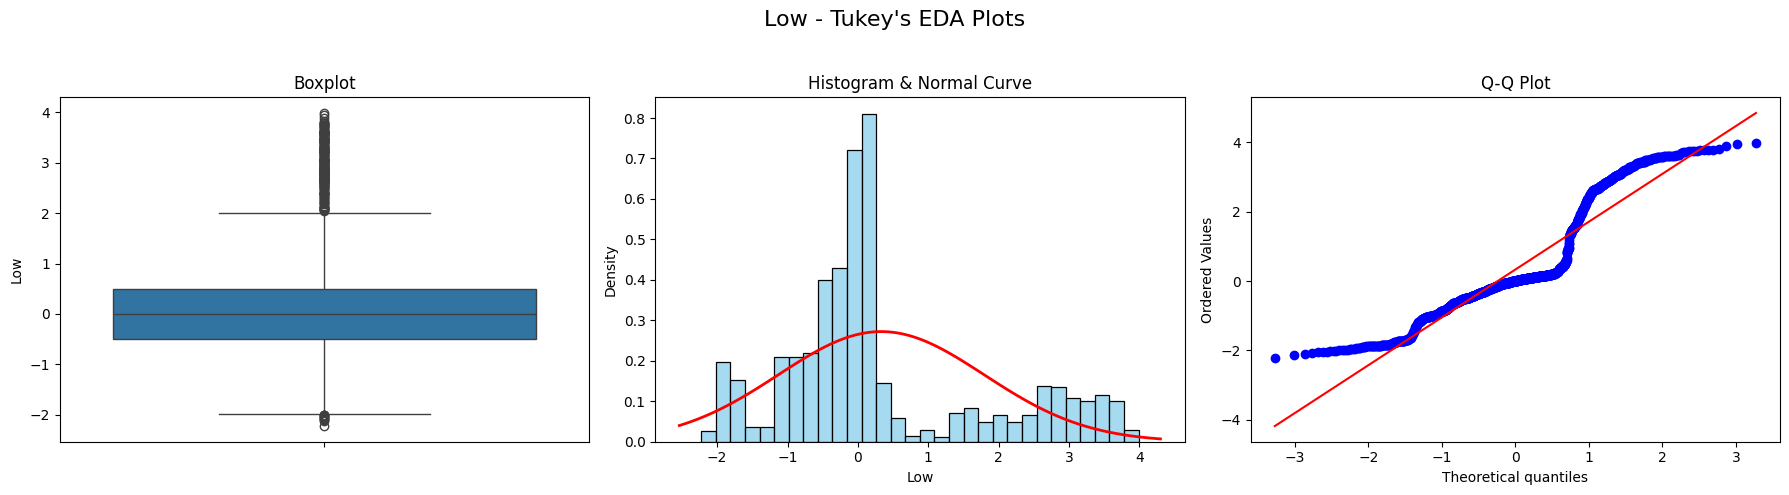

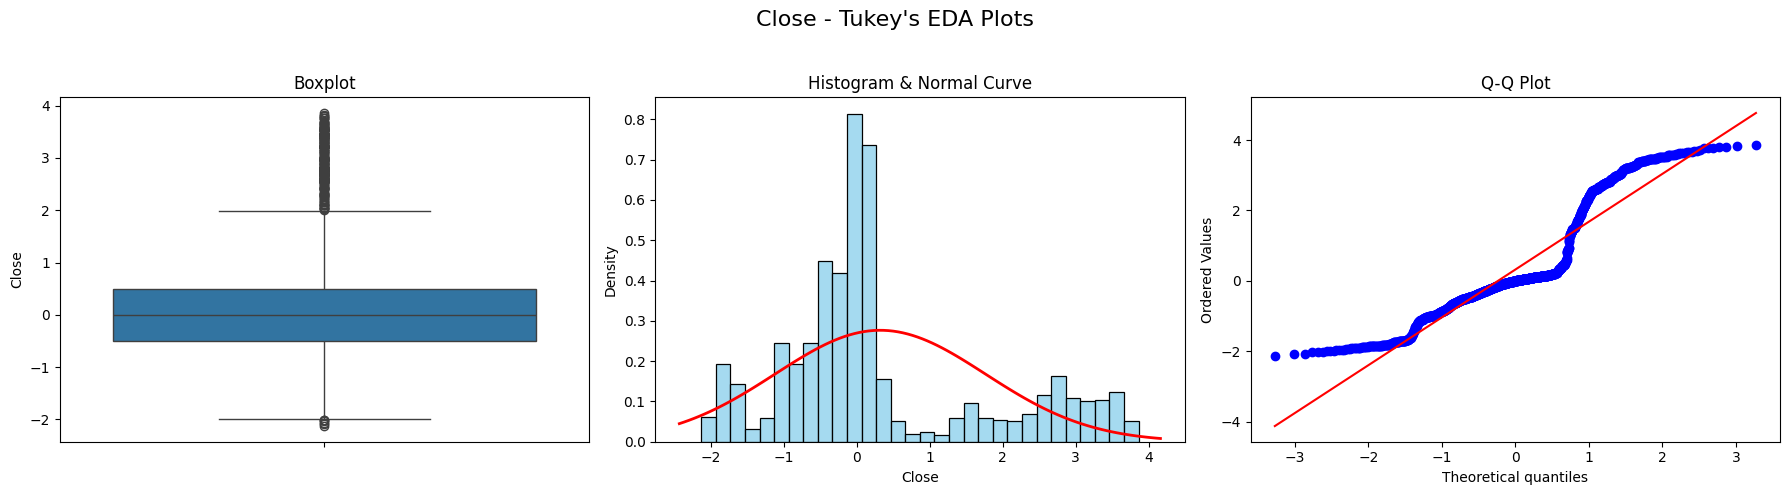

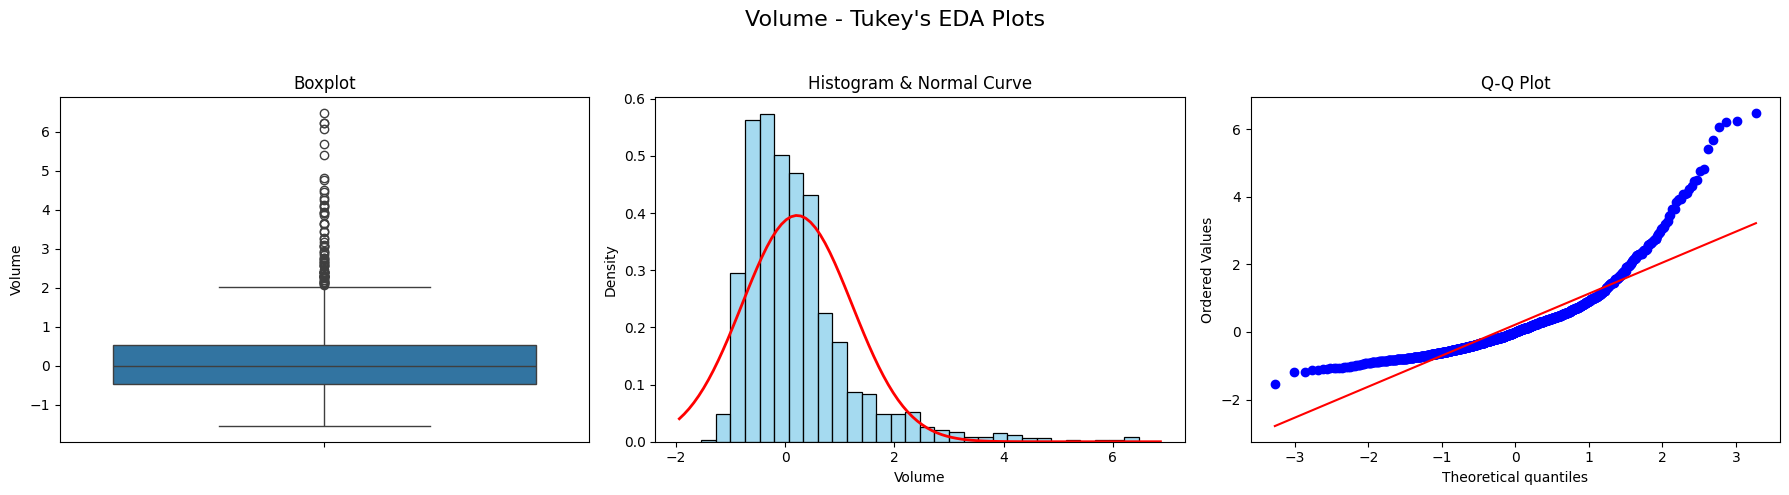

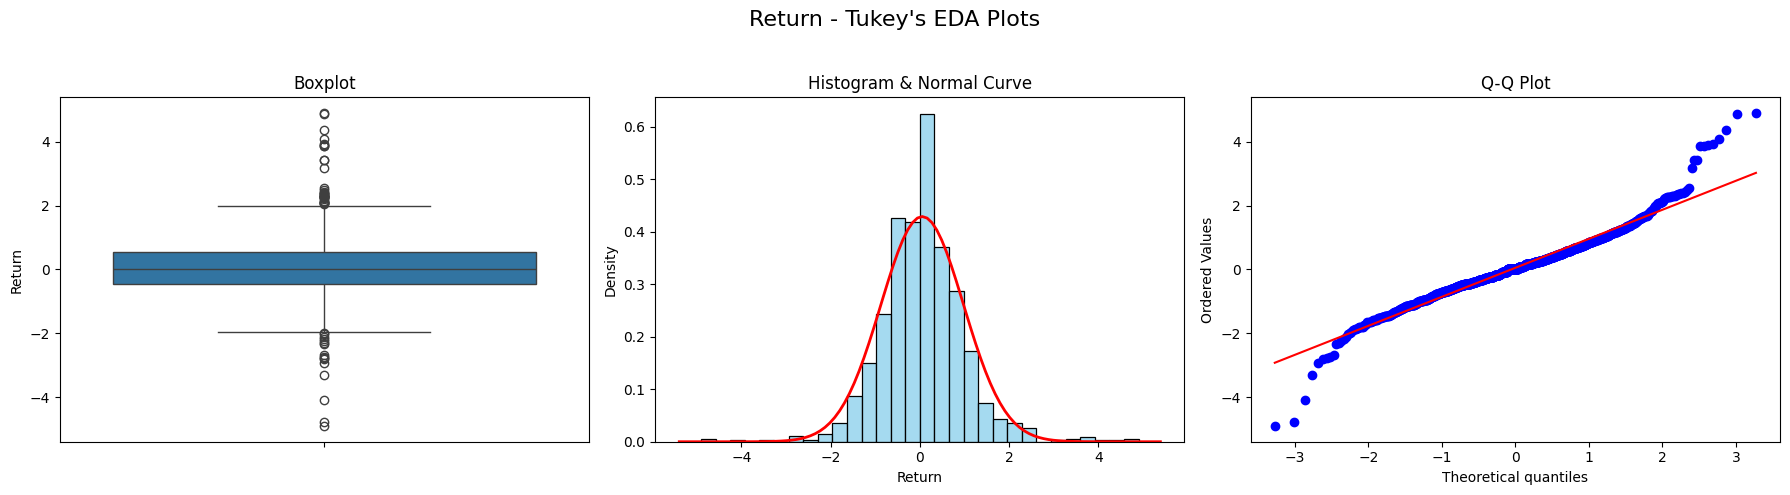

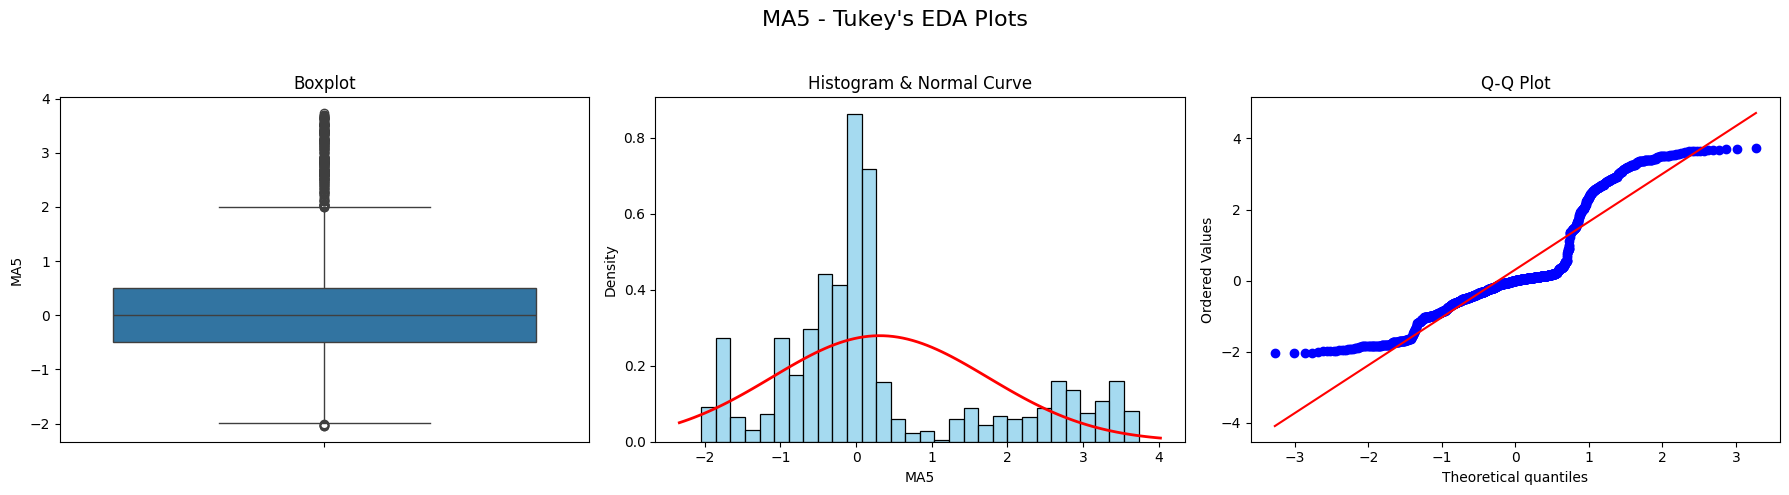

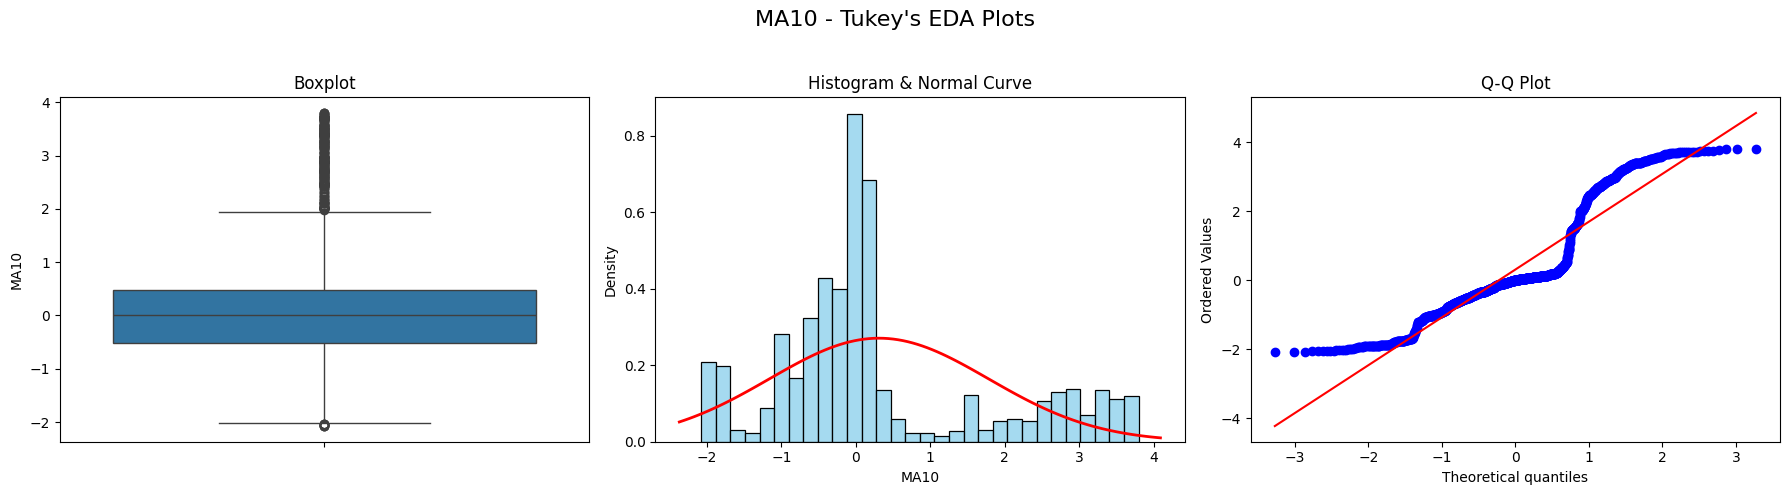

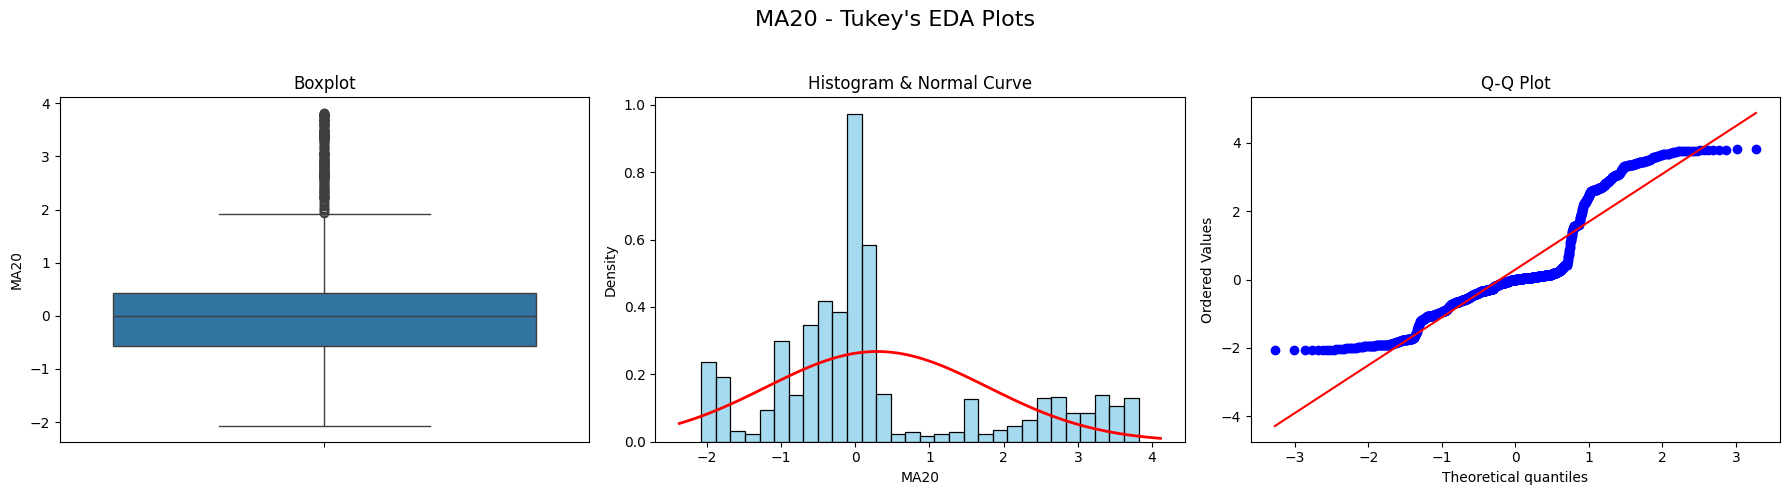

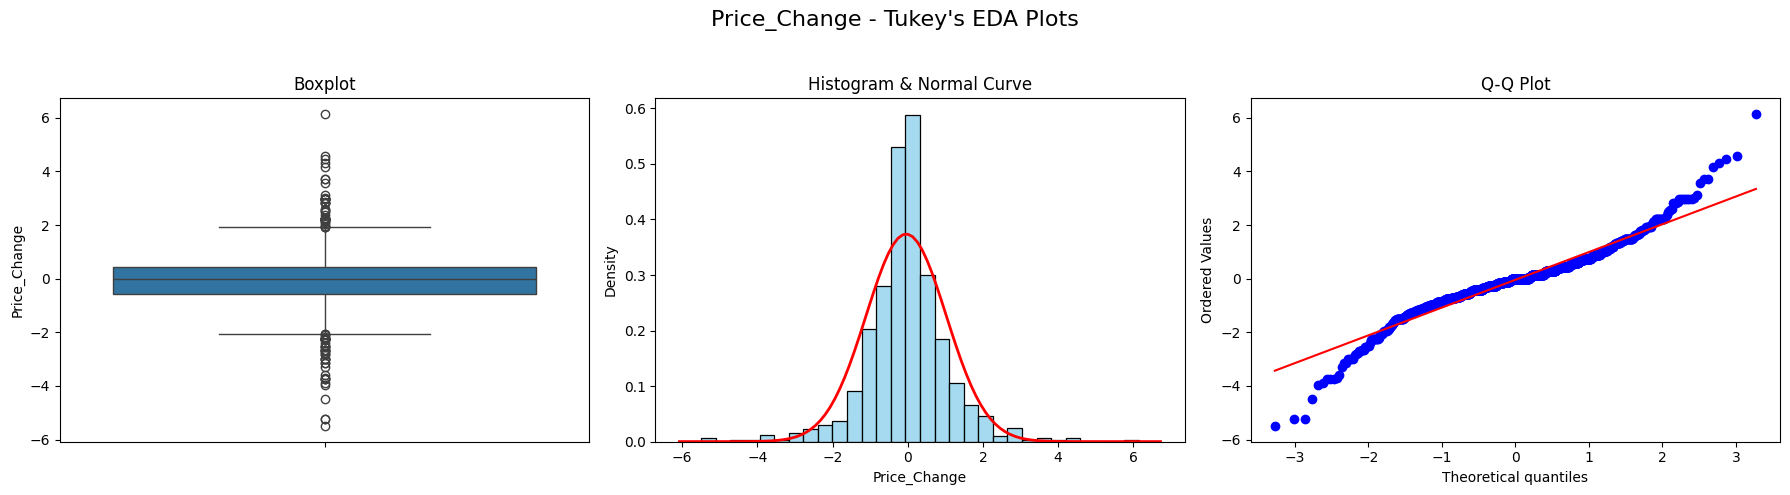

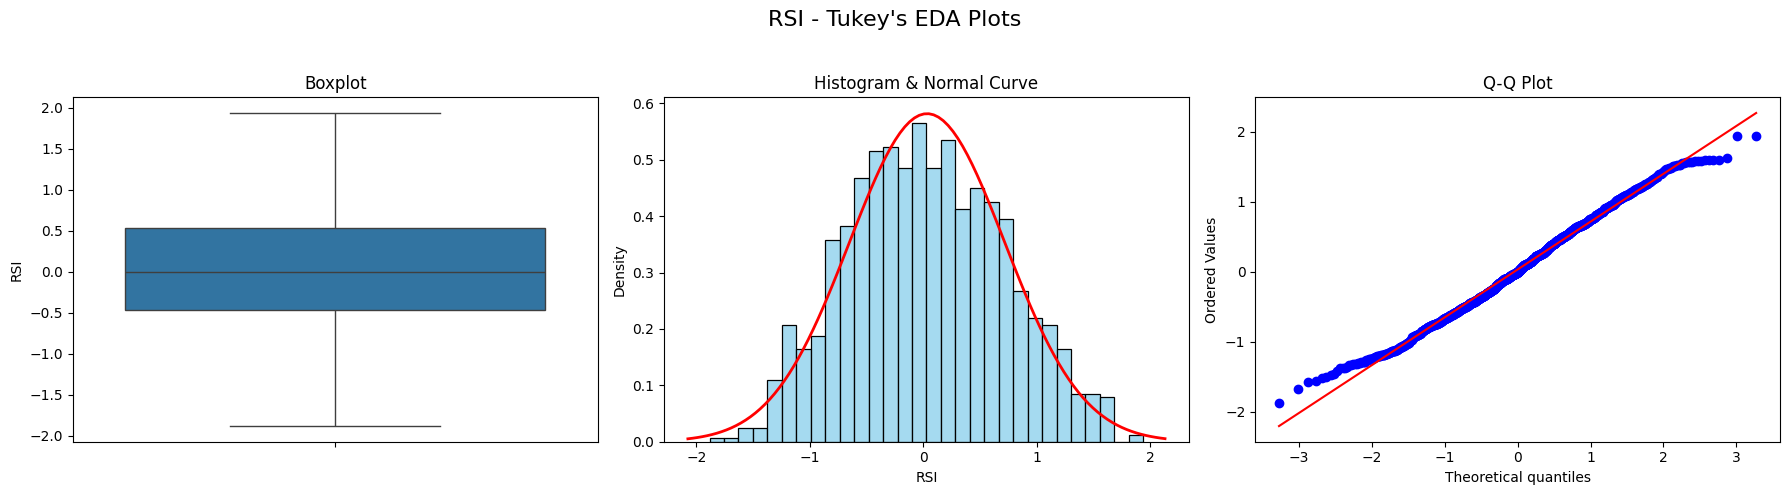

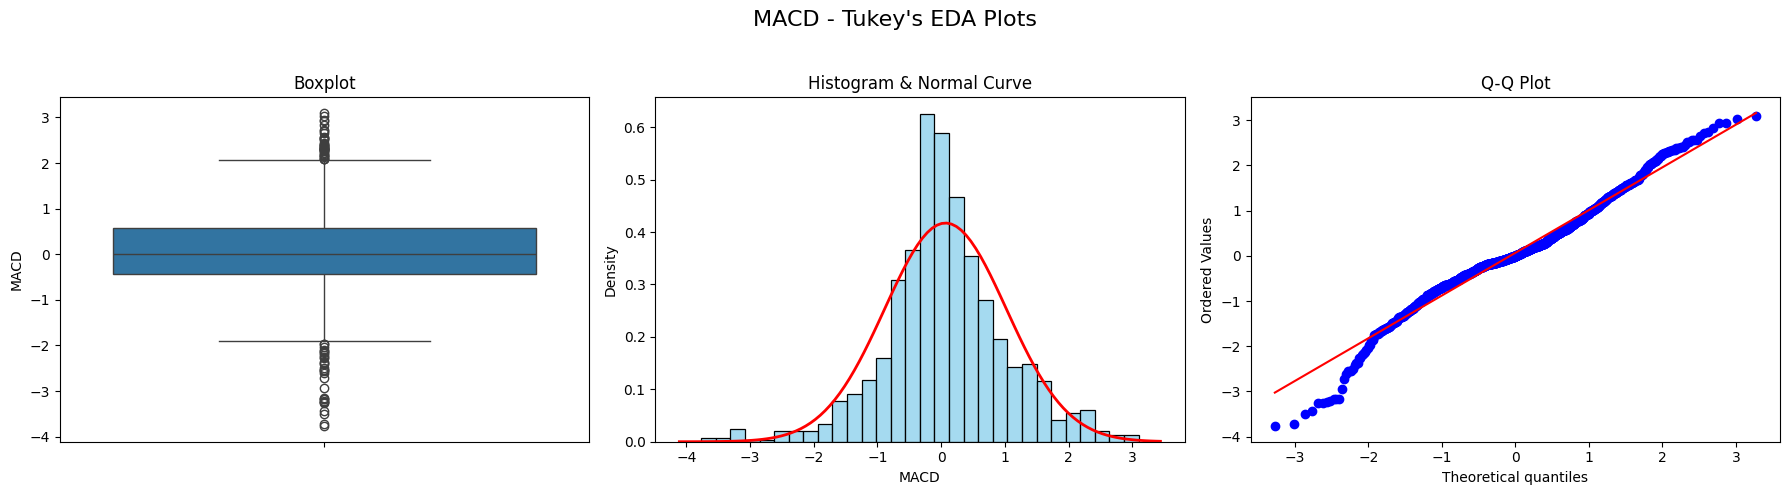

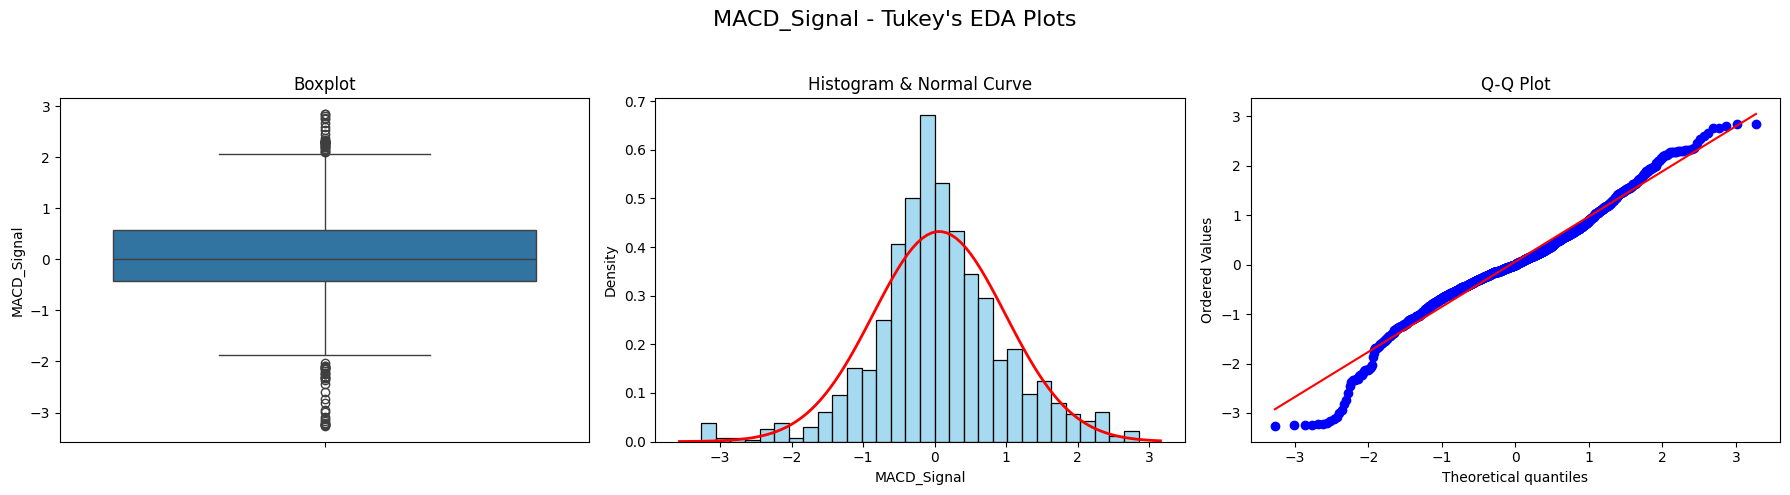

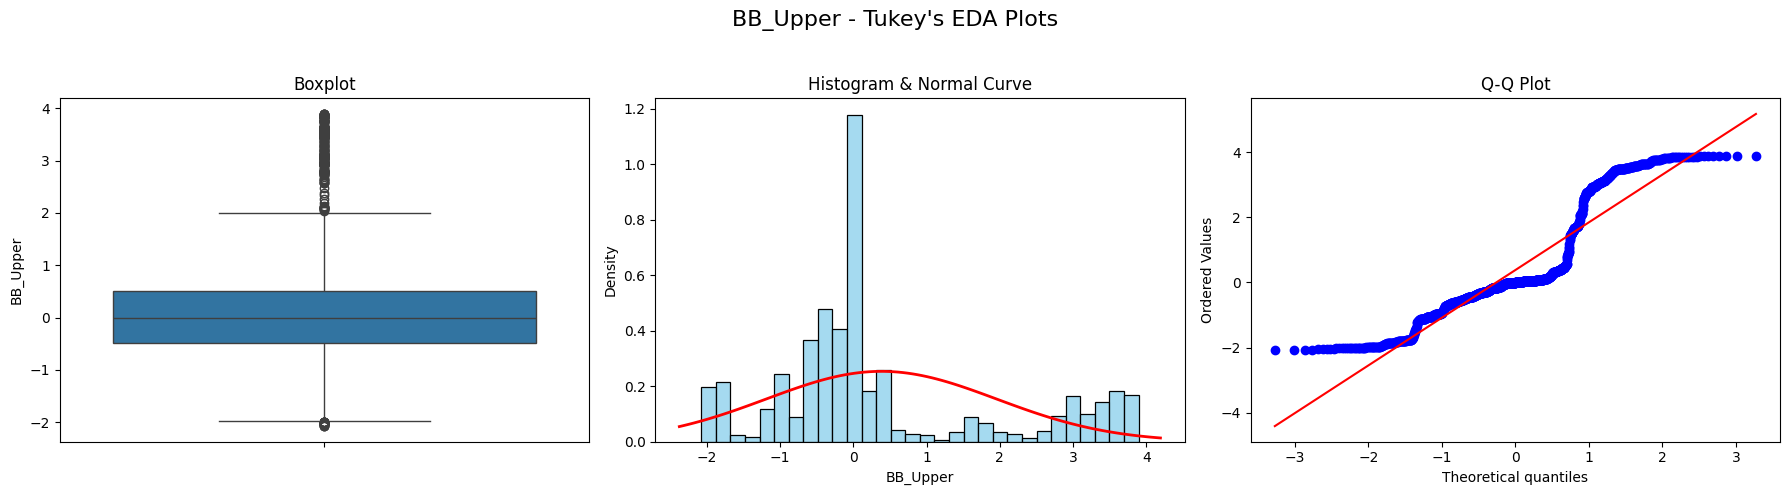

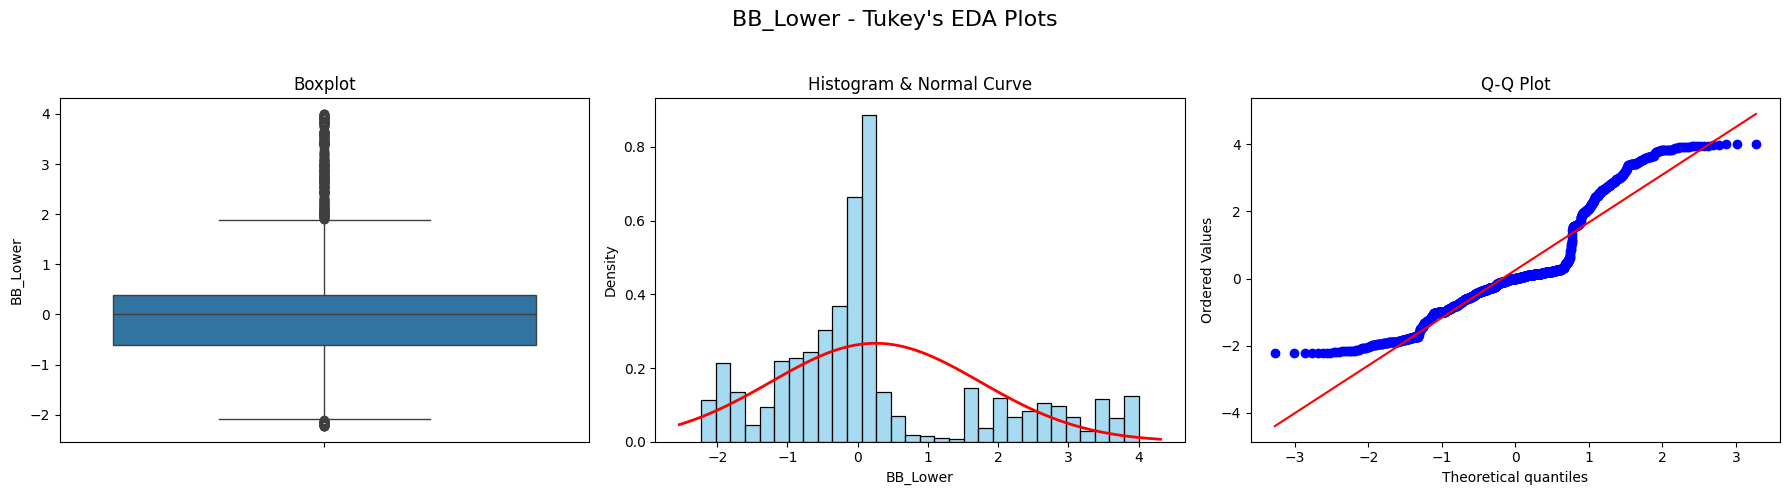

In [ ]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df_robust = pd.read_csv("tsmc2330-2_Robust.csv")

# 需要繪圖的欄位
plot_cols = [col for col in df_robust.columns if col not in ["Date", "Target"]]

for col in plot_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{col} - Tukey's EDA Plots", fontsize=16)

    # 盒鬚圖 (Boxplot)
    sns.boxplot(y=df_robust[col], ax=axes[0])
    axes[0].set_title("Boxplot")

    # 長條圖及常態分佈圖 (Histogram + Normal Curve)
    sns.histplot(df_robust[col], kde=False, stat="density", ax=axes[1], bins=30, color='skyblue')
    # 正態分佈曲線
    mu, std = df_robust[col].mean(), df_robust[col].std()
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    axes[1].plot(x, p, 'r', linewidth=2)
    axes[1].set_title("Histogram & Normal Curve")

    # Q-Q plot
    stats.probplot(df_robust[col], dist="norm", plot=axes[2])
    axes[2].set_title("Q-Q Plot")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

### 特徵選擇：使用Pearson's correlation coefficient 分析特徵相關性

### tsmc2330-2_Robust.csv 熱力圖

In [ ]:
#  選擇特徵變數分析
features_analysis = df_robust.drop(columns=["Date"])

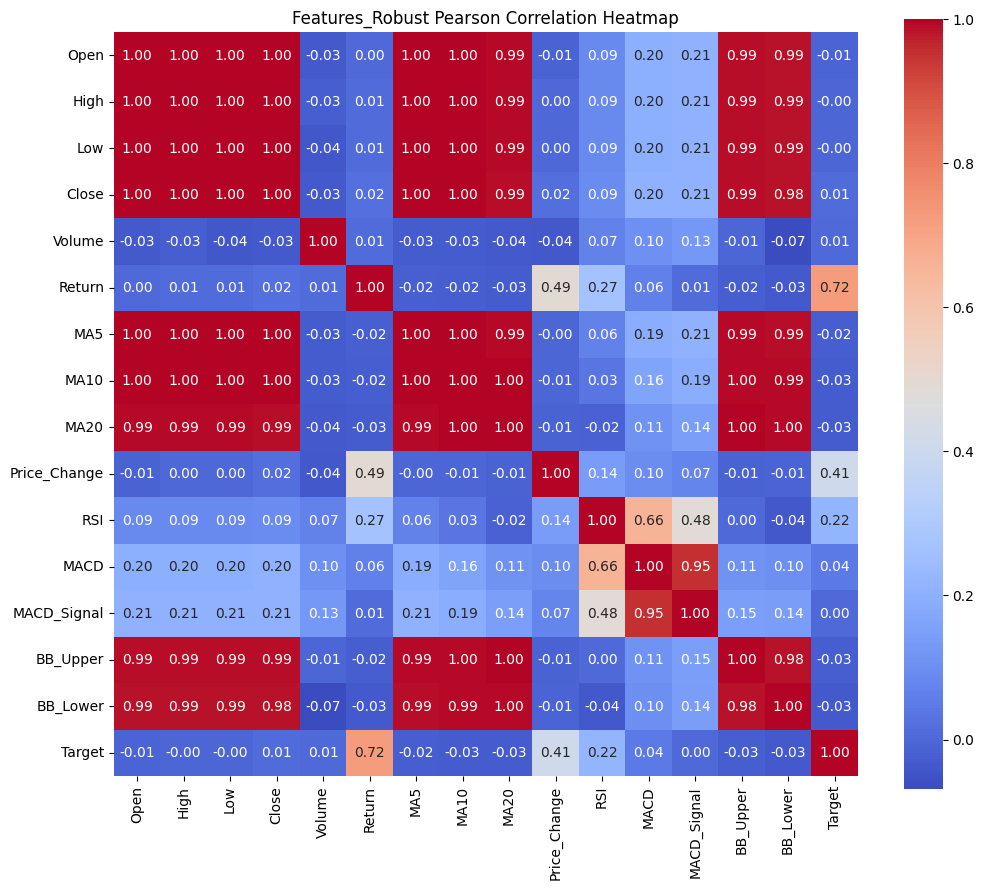

In [ ]:
# 計算 Pearson's correlation coefficient
# features_robust =df_robust.drop(columns=["Column1", "Date"]) 上面已經有設定 feature_robust
corr_matrix = features_analysis.corr(method='pearson')

# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Features_Robust Pearson Correlation Heatmap")
plt.show()

### 由熱力圖分析 Pearson's corelation coefficient, 最相關的特徵，其相關係數如下:
- Return: 0.72
- Price change: 0.42
- RSI: 0.23
由熱力圖也觀察到有特徵重疊的情形

### 因為資料離群值比較多，另使用 Spearman 相關係數分析特徵變數相關性

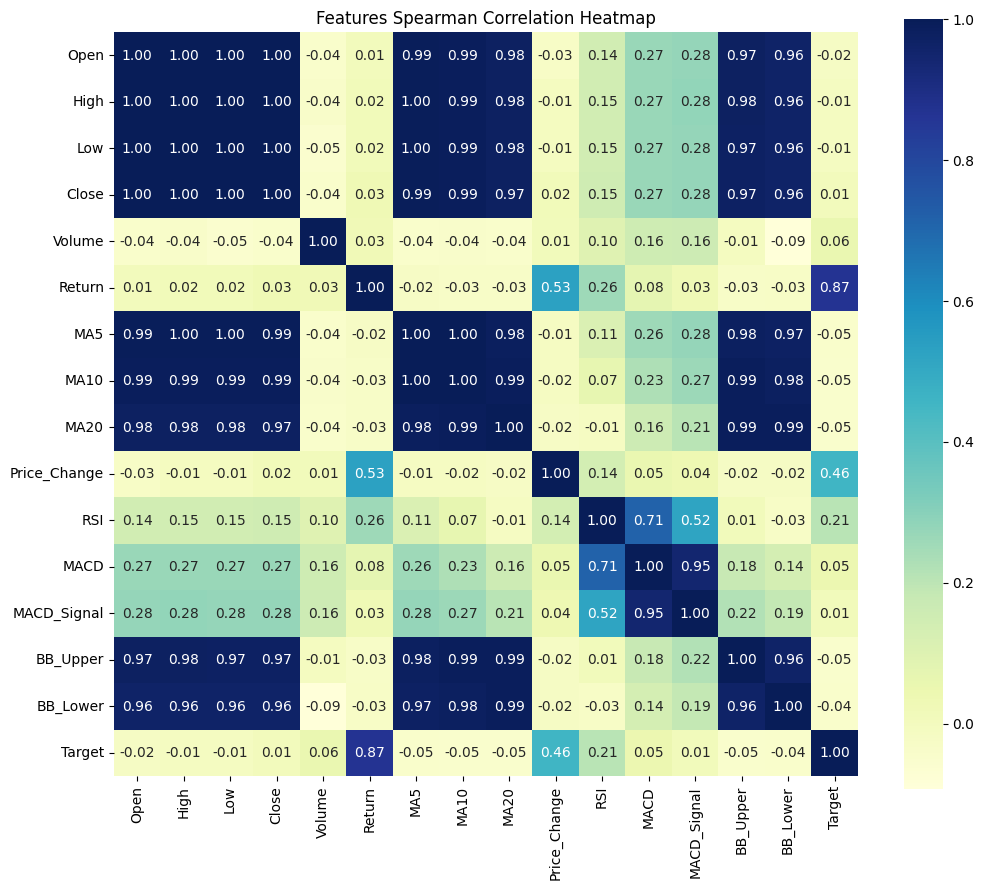

In [ ]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as stats

# 讀取標準化後的資料
df_robust = pd.read_csv("tsmc2330-2_Robust.csv")

# Spearman 相關係數分析
#features_analysis = df_robust.drop(columns=["Date"])  使用上面的設定
corr_matrix_spearman = features_analysis.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_spearman, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Features Spearman Correlation Heatmap")
plt.show()

相關性高的特徵變數及其相關係數:
- Return: 0.89
- Price_Change: 0.47
- RSI: 0.22
由 Spearman 相關係數也觀察到特徵重疊的現象

由Pearson 相關係數發現open, high, low, close 區塊、MA5, MA10, MA20 區塊、BB_upper, BB_lower 區塊幾乎都是 1.00 呈現高度共線，表示這些特徵是重複資訊，需重新建構特徵。
其中，Return, Price_change, RSI 是比較高的係數，表示與 Target 相關。

另外的問題是 Return 的計算是使用（今日的收盤價 - 昨日的收盤價）/ 昨日的收盤價
Target 漲跌也是 今日的收盤價 - 昨日的收盤價，用這樣的方式預測結果會100% 準確，
需使用歷史資料來預測明天的漲跌，否則會有資料洩漏（data leakage) 的問題

#### 重新建構特徵、去空值、設定目標 y

In [ ]:
# Load preprocessed data
df = pd.read_csv('tsmc2330-2_Robust.csv')

## Feature Engineering: Lagged Historical Features
df['Lag1_Close'] = df['Close'].shift(1)
df['Lag1_Return'] = df['Close'].pct_change().shift(1)
df['Lag1_RSI'] = df['RSI'].shift(1)
df['Lag1_MACD'] = df['MACD'].shift(1)
df['Lag1_MACD_Signal'] = df['MACD_Signal'].shift(1)
df['Volume_Change'] = df['Volume'].pct_change().shift(1)
df['MA5_diff'] = (df['MA5'].shift(1) - df['MA10'].shift(1)) / df['MA10'].shift(1)
df['BB_Pressure'] = df['BB_Upper'].shift(1) / df['Close'].shift(1)
df['Target'] = (df['Close'] > df['Close'].shift(1)).astype(int)
df_model = df.dropna()
features = ['Lag1_Close','Lag1_Return','Lag1_RSI','Lag1_MACD','Lag1_MACD_Signal','Volume_Change','MA5_diff','BB_Pressure']
X = df_model[features]
y = df_model['Target']

#### 重做 Pearson's 相關係數分析，卻認特徵沒有共線問題

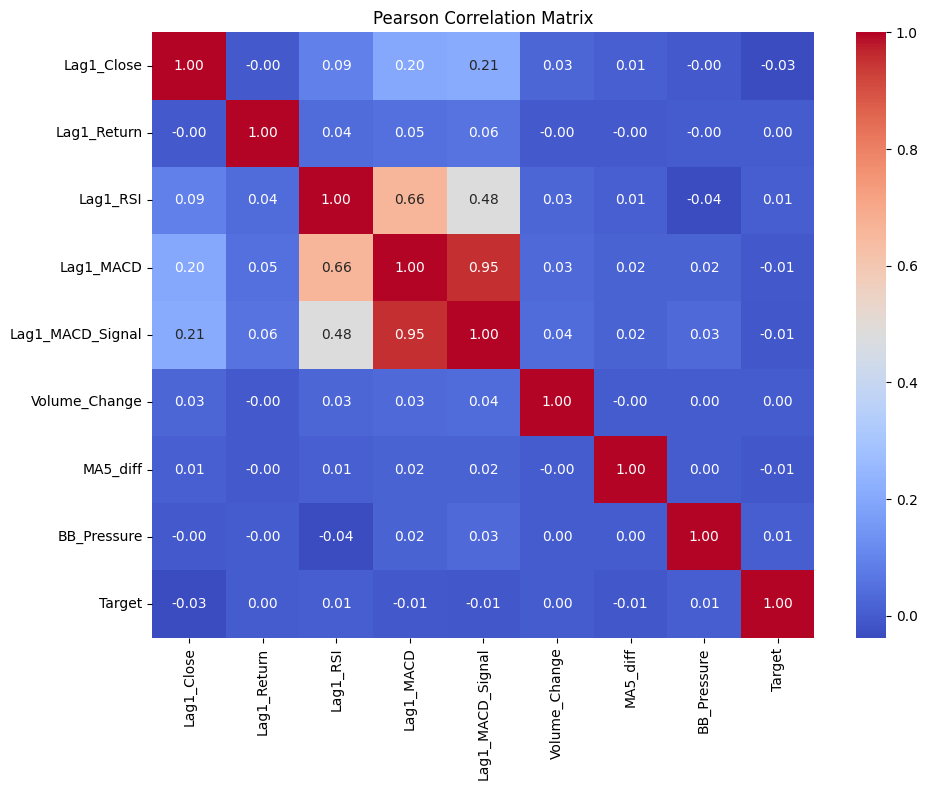

In [ ]:
# Pearson Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_model[features + ['Target']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.show()

從上面可看出 lag1_Close, lag1_RSI, lag1_MACD, lag1_MACD_Signal, MA5_diff, BB_Pressure 相關

#### 資料分割為訓練集(80%)與測試集(20%), 使用 42 號洗牌程序，確認數據分割的結果都完全一樣，讓實驗可以被重現。


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 模型訓練及評估
1. 邏輯迴歸
2. 隨機森林
3. XGBoost

### Logistic Regression
Accuracy: 0.5039, Precision: 0.4941, Recall: 0.6667, F1-score: 0.5676, AUC: 0.5189



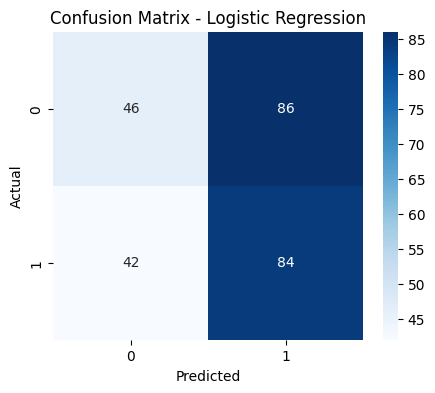

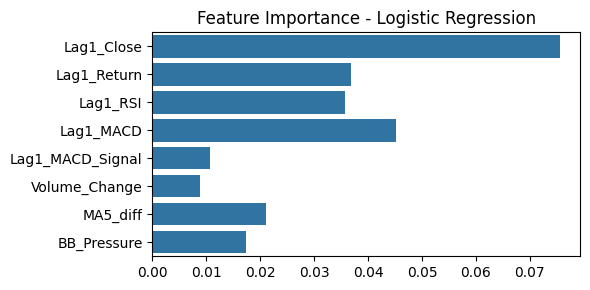

### Random Forest
Accuracy: 0.5116, Precision: 0.5000, Recall: 0.4841, F1-score: 0.4919, AUC: 0.5092



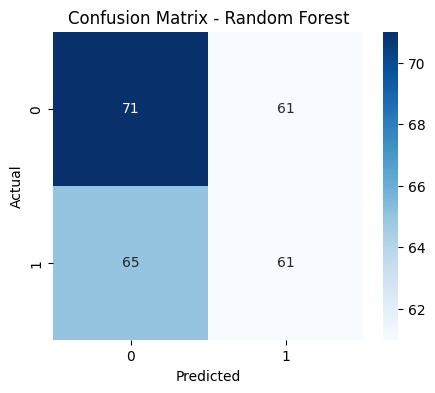

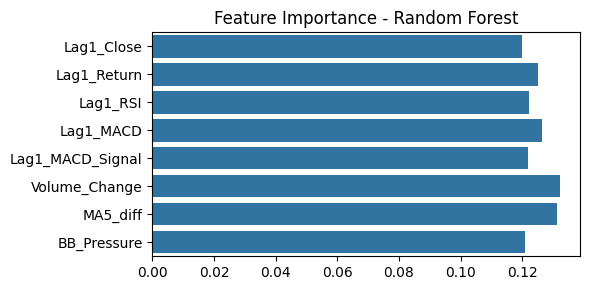

/Volumes/Data/Github/Python-2025_04_25/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:35:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### XGBoost
Accuracy: 0.5155, Precision: 0.5039, Recall: 0.5159, F1-score: 0.5098, AUC: 0.5073



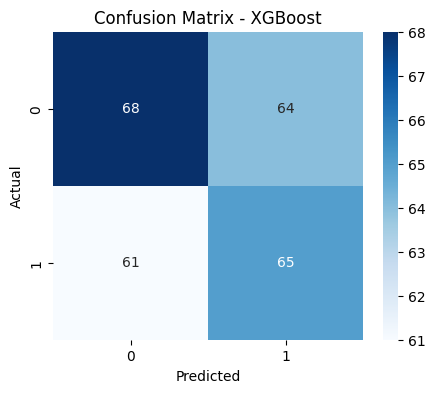

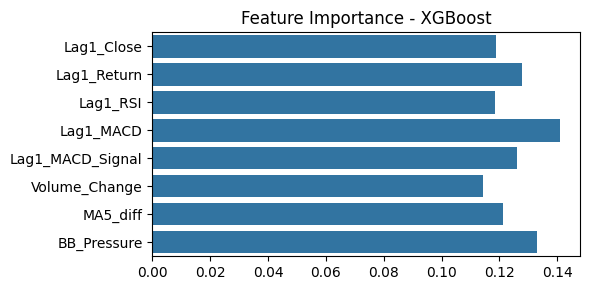

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"### {name}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}, AUC: {auc:.4f}\n")
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
    else:
        imp = np.abs(model.coef_[0])
    plt.figure(figsize=(6,3))
    sns.barplot(x=imp, y=features)
    plt.title(f'Feature Importance - {name}')
    plt.tight_layout()
    plt.show()
    # Store ROC for comparison
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    results[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

## ROC 曲線比較

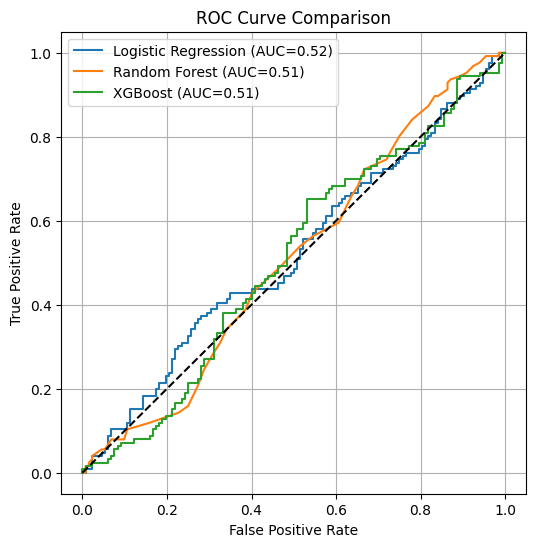

In [ ]:
plt.figure(figsize=(6,6))
for name, res in results.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC={res['auc']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()